<a href="https://colab.research.google.com/github/coimbra574/Ciencias-de-Dados/blob/main/Predicao_Energia_Solar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predição de Geração de Energia Solar

Dados relativos a 2 plantas de geração de energia solar, cada uma contendo duas tabelas: uma com informação sobre a geração, e outra sobre condições ambientais.
Os dados são recolhidos em intervalos de 15 minutos, durante 34 dias.

### Features:
*  **DATE_TIME**: data e hora da medição
*  **PLANT_ID**: identificação de cada planta
*  **SOURCE_KEY**: código de cada inversor?
*  **DC_POWER**: potência DC gerada pelos paineis solares do inversor, durante o intervalo de 15 minutos de medição, em kW.
*  **AC_POWER**: potência AC gerada pelo inversor, durante o intervalo de 15 minutos de medição, em kW.
*  **DAILY_YIELD** : energia acumulada no dia, até aquela data e horário, em kW.
* **TOTAL_YIELD** : energia total acumulada, até aquela data e horário, em kW.
* **AMBIENT_TEMPERATURE** : Temperatura ambiente, em ºC
* **MODULE_TEMPERATURE** : Temperatura nos paines solares, em ºC
* **IRRADIATION** : Irradiação solar durante o intervalo de 15 minutos de medição

dataset disponível em: https://www.kaggle.com/datasets/anikannal/solar-power-generation-data/code

In [13]:
! pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 kB 3.0 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error, \
mean_absolute_error

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importando Dataset

In [3]:
p1_gen = pd.read_csv('/content/drive/MyDrive/Aulas Americanas/Modulo IV - Machine Learning/Plant_1_Generation_Data.csv')
p1_weather = pd.read_csv('/content/drive/MyDrive/Aulas Americanas/Modulo IV - Machine Learning/Plant_1_Weather_Sensor_Data.csv')
p2_gen = pd.read_csv('/content/drive/MyDrive/Aulas Americanas/Modulo IV - Machine Learning/Plant_2_Generation_Data.csv')
p2_weather = pd.read_csv('/content/drive/MyDrive/Aulas Americanas/Modulo IV - Machine Learning/Plant_2_Weather_Sensor_Data.csv')

In [4]:
p1_gen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68778 entries, 0 to 68777
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATE_TIME    68778 non-null  object 
 1   PLANT_ID     68778 non-null  int64  
 2   SOURCE_KEY   68778 non-null  object 
 3   DC_POWER     68778 non-null  float64
 4   AC_POWER     68778 non-null  float64
 5   DAILY_YIELD  68778 non-null  float64
 6   TOTAL_YIELD  68778 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 3.7+ MB


In [5]:
p1_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3182 entries, 0 to 3181
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   DATE_TIME            3182 non-null   object 
 1   PLANT_ID             3182 non-null   int64  
 2   SOURCE_KEY           3182 non-null   object 
 3   AMBIENT_TEMPERATURE  3182 non-null   float64
 4   MODULE_TEMPERATURE   3182 non-null   float64
 5   IRRADIATION          3182 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 149.3+ KB


In [6]:
display(p1_gen.head())
print("")
display(p1_weather.head())

DATE_TIME  PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  \
0  15-05-2020 00:00   4135001  1BY6WEcLGh8j5v7       0.0       0.0   
1  15-05-2020 00:00   4135001  1IF53ai7Xc0U56Y       0.0       0.0   
2  15-05-2020 00:00   4135001  3PZuoBAID5Wc2HD       0.0       0.0   
3  15-05-2020 00:00   4135001  7JYdWkrLSPkdwr4       0.0       0.0   
4  15-05-2020 00:00   4135001  McdE0feGgRqW7Ca       0.0       0.0   

   DAILY_YIELD  TOTAL_YIELD  
0          0.0    6259559.0  
1          0.0    6183645.0  
2          0.0    6987759.0  
3          0.0    7602960.0  
4          0.0    7158964.0

DATE_TIME  PLANT_ID       SOURCE_KEY  AMBIENT_TEMPERATURE  \
0  2020-05-15 00:00:00   4135001  HmiyD2TTLFNqkNe            25.184316   
1  2020-05-15 00:15:00   4135001  HmiyD2TTLFNqkNe            25.084589   
2  2020-05-15 00:30:00   4135001  HmiyD2TTLFNqkNe            24.935753   
3  2020-05-15 00:45:00   4135001  HmiyD2TTLFNqkNe            24.846130   
4  2020-05-15 01:00:00   4135001  HmiyD2TTLFNqkNe            24.621525   

   MODULE_TEMPERATURE  IRRADIATION  
0           22.857507          0.0  
1           22.761668          0.0  
2           22.592306          0.0  
3           22.360852          0.0  
4           22.165423          0.0

## Unindo as duas tabelas (Generation e Weather)

Será feito um merge usando como chave o DATE_TIME. Esta variável está como "object", que será transformada para o tipo "datetime" para padronizar e facilitar a manipulação das datas.

In [7]:
p1_gen['DATE_TIME'] = pd.to_datetime(p1_gen['DATE_TIME'], format='%d-%m-%Y %H:%M')
p1_weather['DATE_TIME'] = pd.to_datetime(p1_weather['DATE_TIME'], format='%Y-%m-%d %H:%M:%S')

In [8]:
display(p1_gen['DATE_TIME'][0] == p1_weather['DATE_TIME'][0])

True

In [9]:
data_1 = pd.merge(p1_gen, p1_weather, on='DATE_TIME', how='inner').drop(columns=['PLANT_ID_x', 'PLANT_ID_y','SOURCE_KEY_y'], axis=1)
data_1 = data_1.rename(columns={'SOURCE_KEY_x': 'SOURCE_KEY'})

## Verificando linhas duplicadas


In [10]:
data_1 = data_1.drop_duplicates()

## Tratando dados categóricos

Temos 1 atributo com dados categóricos: SOURCE_KEY. Os dados parecem estar balanceados:

In [11]:
data_1['SOURCE_KEY'].value_counts()

bvBOhCH3iADSZry    3155
1BY6WEcLGh8j5v7    3154
7JYdWkrLSPkdwr4    3133
VHMLBKoKgIrUVDU    3133
ZnxXDlPa8U1GXgE    3130
ih0vzX44oOqAx2f    3130
z9Y9gH1T5YWrNuG    3125
wCURE6d3bPkepu2    3125
uHbuxQJl8lW7ozc    3125
pkci93gMrogZuBj    3125
iCRJl6heRkivqQ3    3125
rGa61gmuvPhdLxV    3124
sjndEbLyjtCKgGv    3124
McdE0feGgRqW7Ca    3124
zVJPv84UY57bAof    3124
ZoEaEvLYb1n2sOq    3123
zBIq5rxdHJRwDNY    3119
1IF53ai7Xc0U56Y    3118
adLQvlD726eNBSB    3118
WRmjgnKYAwPKWDb    3118
3PZuoBAID5Wc2HD    3118
YxYtjZvoooNbGkE    3104
Name: SOURCE_KEY, dtype: int64

Neste caso, pode ser feito um Target Encoder, considerando a variável de interesse. Sendo DC Power esta variável:

#### Obs: não pode ser usado com modelos não-supervisionados, como o knn.

In [14]:
from category_encoders import *

#encoder = TargetEncoder()
#data_1['SOURCE_KEY'] = encoder.fit_transform(data_1['SOURCE_KEY'], data_1['DC_POWER'])
#data_2['SOURCE_KEY'] = encoder.fit_transform(data_2['SOURCE_KEY'], data_2['DC_POWER'])

#data_1.head()

## Criando uma nova variável que indica se é noite ou dia

In [16]:
# 1 para dia e 0 para noite
day_mask_1 = (data_1['DATE_TIME'].dt.hour > 5) & (data_1['DATE_TIME'].dt.hour < 19)

In [17]:
# 1 Para o periodo da manha, e 0 para o periodo da noite
data_1.loc[day_mask_1, 'PERIOD'] = 1
data_1.loc[~day_mask_1, 'PERIOD'] = 0
data_1['PERIOD'].value_counts()

1.0    37927
0.0    30847
Name: PERIOD, dtype: int64

## DAILY_YIELD para cada inversor

In [21]:
#plt.plot(data_1['DATE_TIME'], data_1['DAILY_YIELD'])
import plotly.express as px
plt.figure(figsize=(10,6))
fig = px.scatter(data_1, x="DATE_TIME", y="DAILY_YIELD", color='SOURCE_KEY')
fig.show()

<Figure size 1000x600 with 0 Axes>

## Verificando a correlação entre os atributos

Text(0.5, 1.0, 'Planta 1')

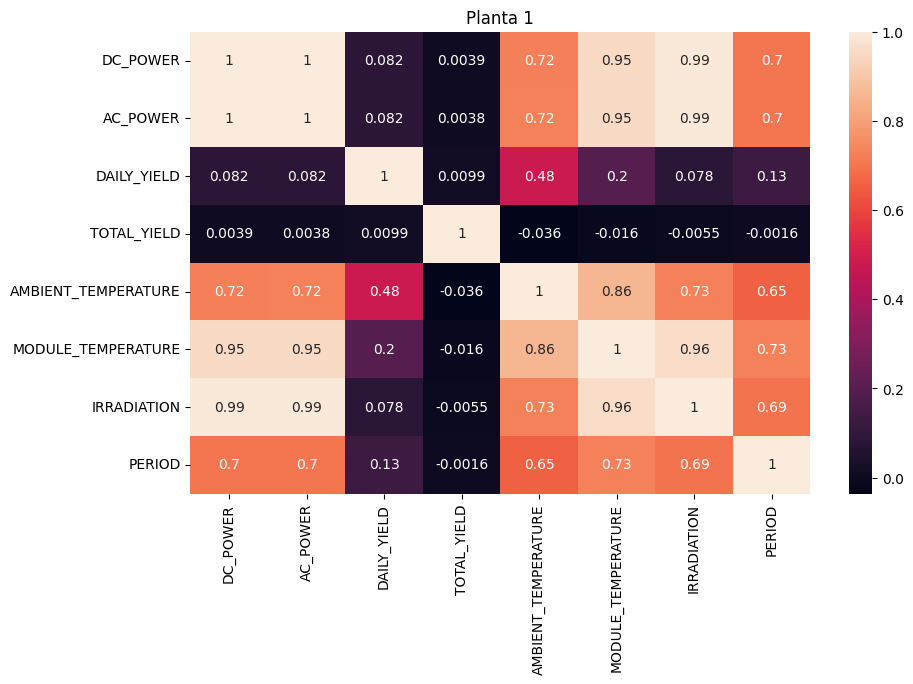

In [22]:
fig, ax = plt.subplots(1, figsize=(10,6))
ax1 = sns.heatmap(data_1.corr(), annot=True, ax=ax)
ax1.set_title('Planta 1')

Espera-se que o DC_POWER e o AC_POWER sejam dados colineares, já que a potência DC é convertida para potência AC pelo conversor, com uma certa quantidade de perda. Verificando estes dois atributos:

Text(0.5, 1.0, 'Planta 1')

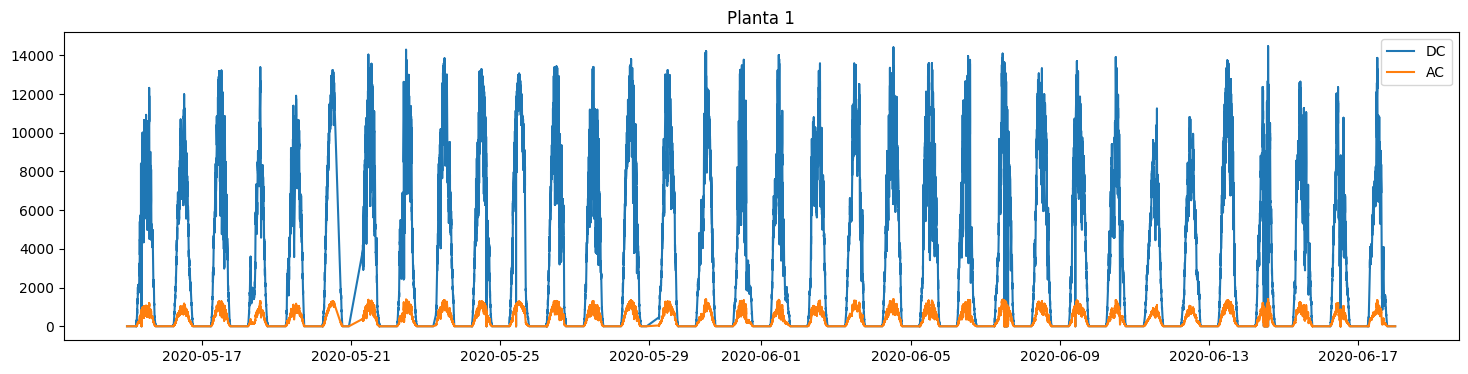

In [23]:
fig, ax = plt.subplots(1, figsize=(18, 4))
ax.plot(data_1['DATE_TIME'], data_1['DC_POWER'])
ax.plot(data_1['DATE_TIME'], data_1['AC_POWER'])
ax.legend(['DC', 'AC'])
ax.set_title('Planta 1')

Text(0.5, 1.0, 'Planta 1')

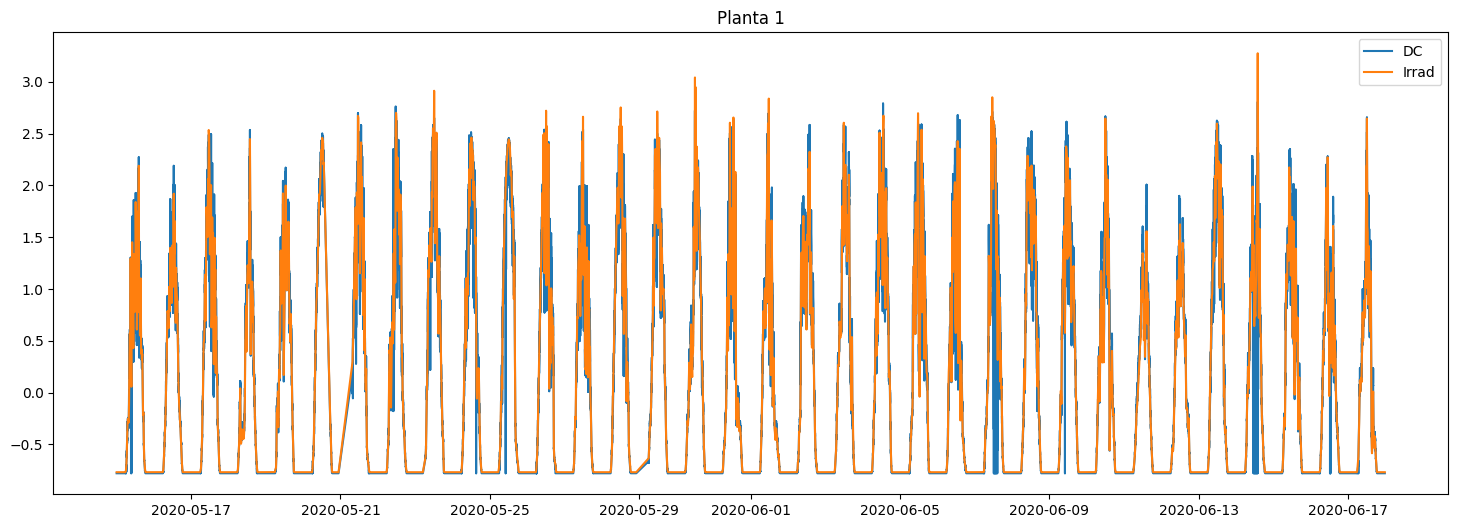

In [24]:
scaler = StandardScaler()
dc = scaler.fit_transform(data_1['DC_POWER'].values.reshape(-1,1))
ac = scaler.fit_transform(data_1['IRRADIATION'].values.reshape(-1,1))


fig, ax = plt.subplots(1, figsize=(18, 6))
ax.plot(data_1['DATE_TIME'], dc)
ax.plot(data_1['DATE_TIME'], ac)
ax.legend(['DC', 'Irrad'])
ax.set_title('Planta 1')

No heatmap de correlação podemos ver que o DC_POWER é quase 100% linearmente correlacionado com a irradiação para a planta 1, mas não tem quase nenhuma correlação com a planta  2. Isto não faz muito sentido, visto que é esperado que quanto maior a irradiação solar, maior também é a energia produzida. Verificando:

Text(0.5, 1.0, 'Planta 1')

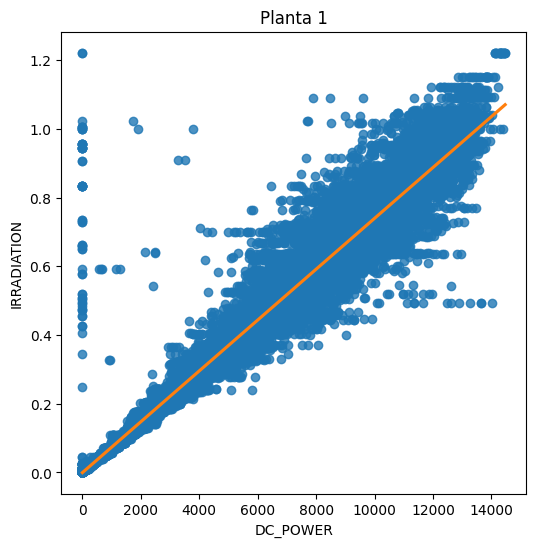

In [25]:
fig, ax = plt.subplots(1, figsize=(6,6))
sns.regplot(x=data_1['DC_POWER'], y=data_1['IRRADIATION'], line_kws={"color": "C1"}, ax=ax)
ax.set_title('Planta 1')


Uma coisa que pode ter acontecido é que a usina na planta 2 parou de funcionar por alguns períodos significativos, onde existia irradiação mas não havia produção de energia. Verificando:

Analisando pras outras features:

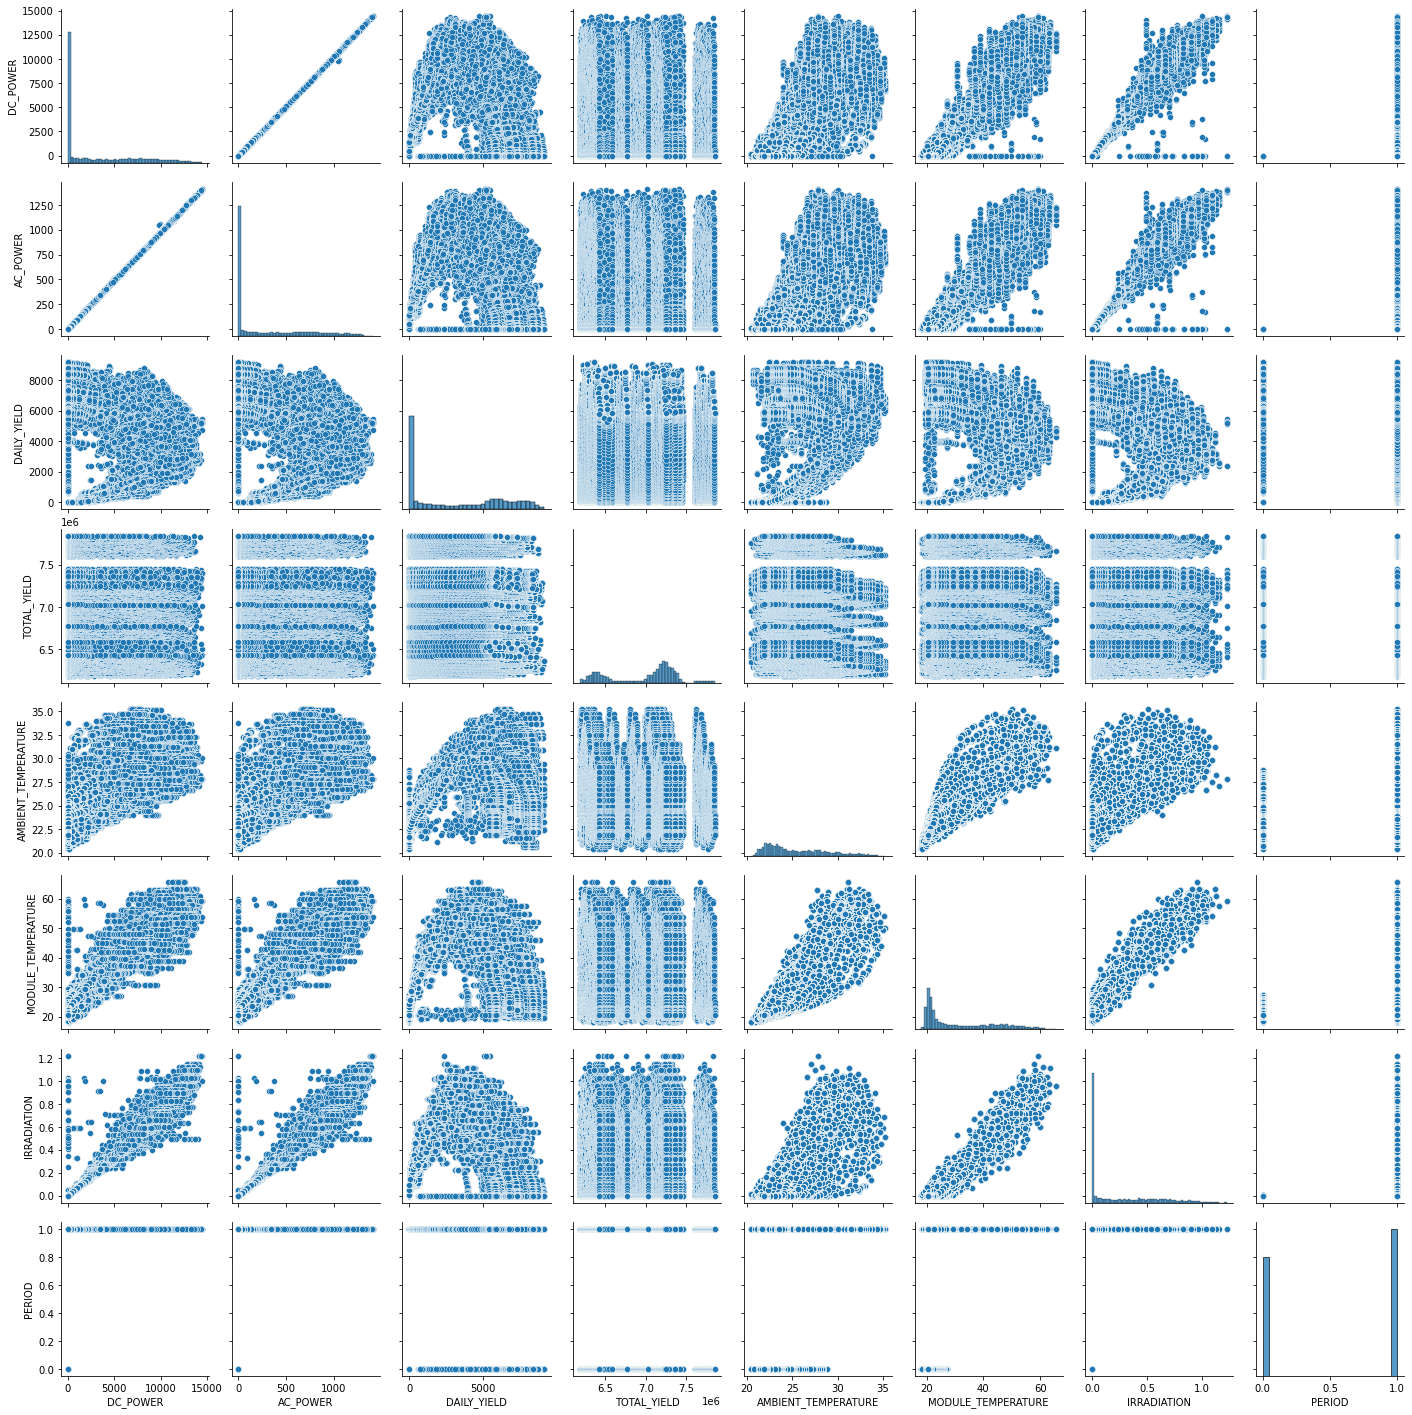

In [ ]:
sns.pairplot(data_1)

Parece que existe uma relação entre DAILY_YIELD que é não linear, e portanto não foi considerada pela correlação de Pearson feita anteriormente. Gerando a tabela utilizando a correlação de Spearman, que considera também relações não-lineares:

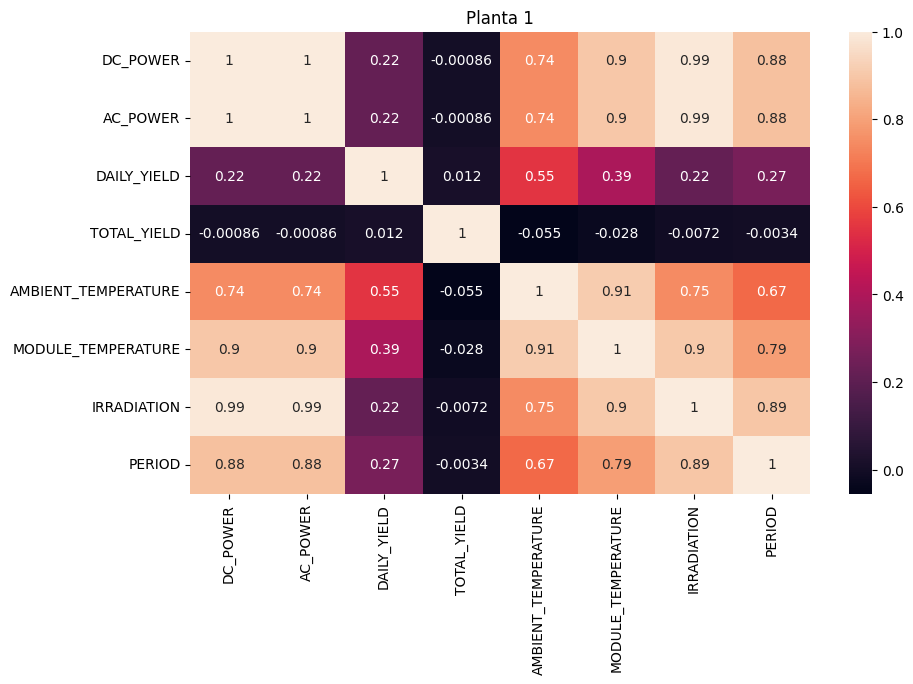

In [27]:
fig, ax = plt.subplots(1, figsize=(10,6))
ax1 = sns.heatmap(data_1.corr('spearman'), annot=True, ax=ax)
ax1.set_title('Planta 1')
fig.show()

Queremos calcular a geração de energia deste sistema para uma possível aplicação em previsão, então nosso target será ou AC_POWER ou DC_POWER. Como o AC_POWER envolve a conversão pelo inversor, com perdas e sujeito a falhas/ruídos, o target usado será o DC_POWER. Temos que avaliar, então, quais atributos serão necessários para estimar o DC_POWER. Pelo heatmap de correlação, já vemos que o SOURCE_KEY e o TOTAL_YIELD são praticamente descorrelacionados com o DC_POWER e portanto serão descartadas.
<br>
<br>

## Modelo de KNN

Prevendo o DC_POWER apenas com as variáveis de temperatura.

In [ ]:
x = data_1[['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE']]
y = data_1['DC_POWER']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold


pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', KNeighborsRegressor())
])


In [ ]:
kfold = KFold(n_splits=3, shuffle=True, random_state=42)

params = {
    'model__n_neighbors' : range(1, 100, 5)
}

lr_search = GridSearchCV(
    estimator=pipe,
    param_grid=params,
    refit=True,
    cv=kfold,
    scoring='explained_variance'
)

model_fit = lr_search.fit(x_train, y_train)

In [ ]:
model_fit.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', KNeighborsRegressor(n_neighbors=11))])

In [ ]:
predicted = model_fit.best_estimator_.predict(x_train)
display(r2_score(y_train, predicted))
display(np.sqrt(mean_absolute_error(y_train, predicted)))
display(np.sqrt(mean_squared_error(y_train, predicted)))

0.9864609492592677

12.719585580963196

470.14400563864825

In [ ]:
predicted = model_fit.best_estimator_.predict(x_test)
display(r2_score(y_test, predicted))
display(np.sqrt(mean_absolute_error(y_test, predicted)))
display(np.sqrt(mean_squared_error(y_test, predicted)))

0.9864382037516111

13.000456499873044

468.1410916762005

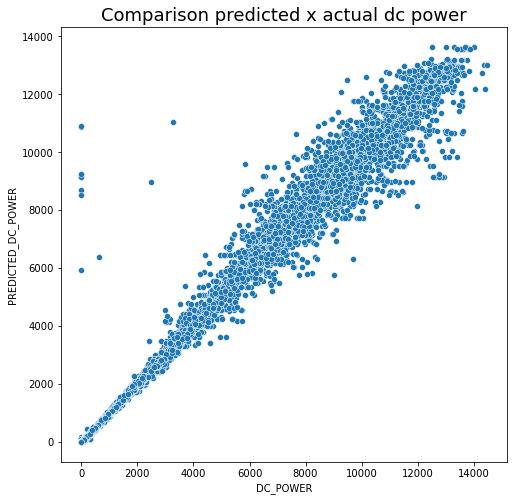

In [ ]:

plt.figure(figsize=(8,8))
fig = sns.scatterplot(x=y_test, y=predicted)
plt.ylabel('PREDICTED_DC_POWER')
plt.title('Comparison predicted x actual dc power', fontsize=18)
plt.show()